<a href="https://colab.research.google.com/github/insancs/clean-messy-rooms/blob/main/CNN_Clean_vs_Messy_Room.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download Dataset

In [ ]:
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/raw/main/ml_pemula_academy/messy-vs-clean-room.zip \
  -O /tmp/messy_vs_clean_room.zip

--2021-10-12 08:35:59--  https://github.com/dicodingacademy/assets/raw/main/ml_pemula_academy/messy-vs-clean-room.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pemula_academy/messy-vs-clean-room.zip [following]
--2021-10-12 08:35:59--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pemula_academy/messy-vs-clean-room.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70392746 (67M) [application/zip]
Saving to: ‘/tmp/messy_vs_clean_room.zip’

/tmp/messy_vs_clean 100%[===================>]  67.13M   216MB/s    in 0.3s    

2021-10-12 08:36

# Extract Dataset

In [ ]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/messy_vs_clean_room.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
os.listdir('/tmp/images/train')

['clean', 'messy']

In [ ]:
os.listdir('/tmp/images/val')

['clean', 'messy']

In [ ]:
# membuat direktori ruangan rapi pada direktori data training
train_clean_dir = os.path.join(train_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data training
train_messy_dir = os.path.join(train_dir, 'messy')

# membuat direktori ruangan rapi pada direktori data validasi
validation_clean_dir = os.path.join(validation_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data validasi
validation_messy_dir = os.path.join(validation_dir, 'messy')

# Image Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Build a Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 512)      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
)

Epoch 1/25
25/25 [==============================] - 10s 357ms/step - loss: 0.7313 - accuracy: 0.5200 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 9s 342ms/step - loss: 0.6695 - accuracy: 0.6100 - val_loss: 0.9852 - val_accuracy: 0.5000
Epoch 3/25
25/25 [==============================] - 9s 343ms/step - loss: 0.6375 - accuracy: 0.7100 - val_loss: 0.9400 - val_accuracy: 0.5000
Epoch 4/25
25/25 [==============================] - 8s 335ms/step - loss: 0.6321 - accuracy: 0.6900 - val_loss: 0.5265 - val_accuracy: 0.7500
Epoch 5/25
25/25 [==============================] - 8s 330ms/step - loss: 0.6295 - accuracy: 0.6700 - val_loss: 0.4434 - val_accuracy: 0.8500
Epoch 6/25
25/25 [==============================] - 8s 317ms/step - loss: 0.5873 - accuracy: 0.7200 - val_loss: 0.5528 - val_accuracy: 0.6500
Epoch 7/25
25/25 [==============================] - 8s 327ms/step - loss: 0.6242 - accuracy: 0.7200 - val_loss: 0.4902 - val_accuracy: 0.9000
Epoch

# Plotting Accuracy and Loss

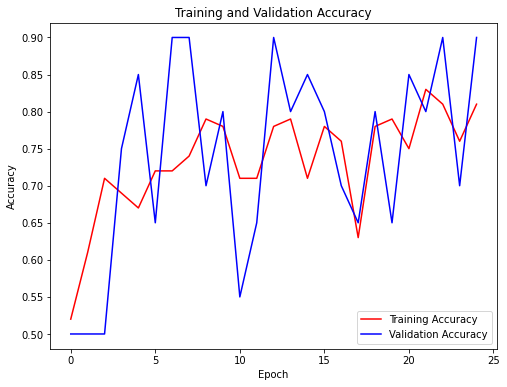

In [ ]:
import matplotlib.pyplot as plt

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

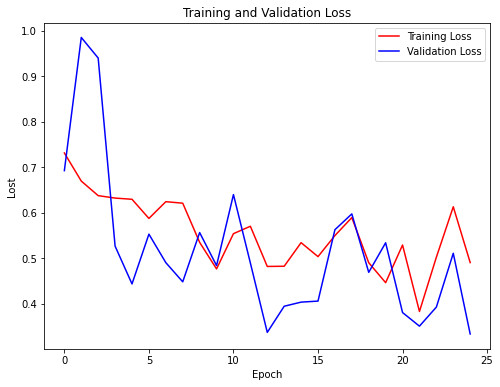

In [ ]:
# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss 
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Lost')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

# Predict Image

Saving m.jpg to m (1).jpg
m.jpg
The room is messy


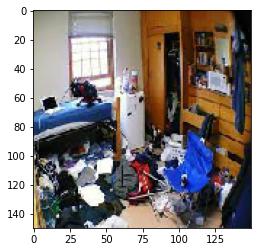

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('The room is clean')
  else:
    print('The room is messy')